# Welcome to TCAP!

This guide will take you through the process of creating text embeddings for Amazon products based on their reviews. We'll show you how to clean and preprocess the data, extract text statistics, and create embeddings. The end result will be a trained model that can be used to find products with similar meanings. Give it a try and see how well it works!

The output of this process will include the embeddings and a trained model. We'll then demonstrate how to use the similarity function to find products with similar meanings (by searching for a specific product).

# Install

In [ ]:
!pip install tcap==2.23 # takes 2-3 minutes to run from scratch
!pip install matplotlib==3.1.3

# Imports

In [3]:
import tcap 
from tcap import run_full_cycle
from tcap.data_loader import webtext_data
import pandas as pd
from tcap.run_full_cycle import run_tcap, DataSpec
from tcap.applications.sanity.teacup import find_similar_texts
from tcap.features_engineering.feature_main import FeatureExtraction
from tcap.cleaning.cleaning_func import TextCleaner
from tcap.preprocessing.preprocessing_func import TextPreprocessor

# Amazon product reviews data

In [5]:
# We will be using reviews data from https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
# We will focus on the top 50 products with the most reviews
# To begin, we will import the necessary libraries from Google Colab
# And we will upload the data file using the following code:

from google.colab import files
uploaded = files.upload()

Saving amazon_reviews.csv to amazon_reviews.csv


In [7]:
data = pd.read_csv("amazon_reviews.csv")
data.shape

(46213, 5)

In [8]:
# First, we will group the data at the product level and sample the reviews.
# Keep in mind that taking more samples per product will yield better results.
data = data.sample(frac=1,random_state=0).reset_index(drop=True)
df_text = data[['Text','ProductId']].groupby("ProductId").\
    agg({'Text':lambda x: '\n'.join(x.sample(n=5, random_state=0))}).\
         reset_index()

df_summary = data[['Summary','ProductId']].groupby("ProductId").\
    agg({'Summary':lambda x: '\n'.join(x.sample(n=20, random_state=0))}).\
         reset_index()

merged_df = pd.merge(df_text, df_summary, on='ProductId')

# Run TCAP 

## Detect similar products based on review summary



***************************************
*** Creating report using TCAP: 🍵 ***
***************************************
We're getting ready to start our data journey with TCAP.
First, we'll be cleaning the text data to ensure that it is free of any unnecessary information. This will make it ready for further analysis.
Next, we'll be preprocessing the text data so that it's in the right format for feature extraction.
With the text data prepped and ready, we'll dive deeper by analyzing it to understand its characteristics and generate statistics.
With a good understanding of the text data, we'll move on to extracting features from it. This will allow us to represent the text data in a numerical format.
Before training the model, we'll analyze the extracted features to understand their relationship with the target variable.
With all the preparation done, we'll now move on to training the model using the extracted features and evaluate its performance.
Finally, we'll conduct a model analysis

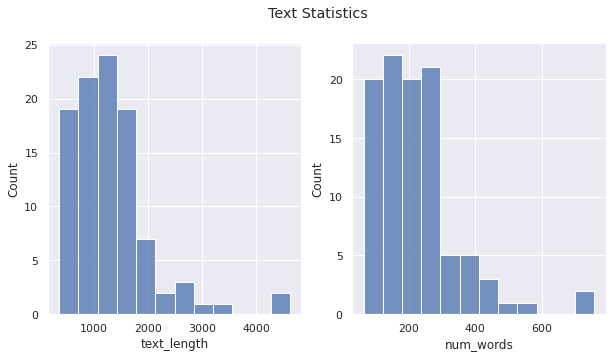

One of the most basic text analysis techniques is counting the frequency of words in the text. The following report shows the most common words in the text data, which can give us an idea of the overall topic and content of the text.



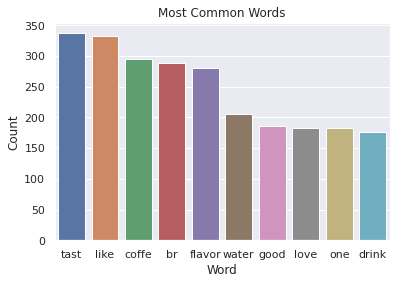

[('tast', 337), ('like', 333), ('coffe', 295), ('br', 288), ('flavor', 280), ('water', 205), ('good', 186), ('love', 182), ('one', 182), ('drink', 177)]
A word cloud is a visual representation of the most common words in a piece of text, where the size of each word corresponds to its frequency. The word cloud can help us quickly identify the main themes and topics in the text data.



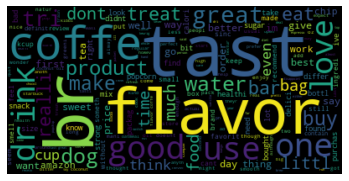

Sentiment analysis is a technique used to determine the emotional tone of a piece of text. The following report shows the sentiment of the text data and provides a breakdown of positive, negative, and neutral sentiments.

{'positive_count': 100, 'negative_count': 0, 'neutral_count': 0, 'positive_percent': 100.0, 'negative_percent': 0.0, 'neutral_percent': 0.0}


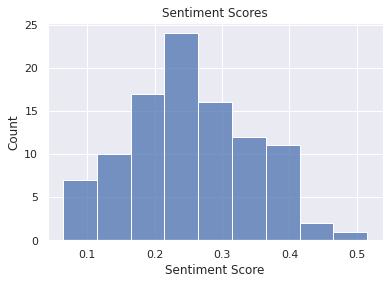

Corex is a topic modeling technique that helps identify latent topics in the text data. The following report shows the top topics extracted from the text data and provides a word cloud for each topic.

0: left, wast, corn, toss, pretti good, syrup, plastic bottl, favorit, use, problem
1: stir, chicken flavor, star, regular, empti, drop, especi, chili, feel, smell like
2: travel, set, homemad, jet fuel, guilt, avail, wait, butter, fast, spice
3: bought, benefit, love coconut, leav, soft, coupl, gobbl, good flavor, lot, friend
4: reorder, fact, espresso, bring, understand, afford, everi day, futur, pretti, sumatra
5: buy case, eat anyth, use cook, actual, healthier, turn, earli, exactli, stop, mile
6: larg, review, old, bud, candi, learn, timebr, plu, groceri, isnt
7: bed, someon, tend, flavor drink, expect, overpow, like drink, probabl, water tast, zuke
8: horribl, order, coconut tast, easi, aroma, thing like, decid, wow, replac, zuke mini
9: light, bake, floor, place, sick, hope, tast,

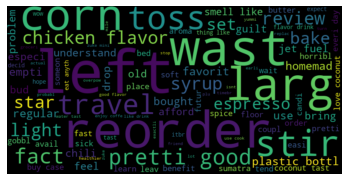

Extracting key sentences from a piece of text is a technique used to identify the most important or representative sentences in the text. The following report shows the top sentences for each topic of the text data.

Key sentences out of based on LSA algorithm: ['bought month old lab keep inhal dinner second flat purchas gift dog ownersbr br took dog day half figur toy first bark sinc frustrat could see smell kibbl couldnt get happi mistak paw watch us pull rope caught take minut eat cup kibbl insidebr br great featuresbr durabl easi wash nalgen type materialbr rope actual flexibl rubber stick make washingsanit easybr screwoff bottom make load toy simplebr transluc bottl see much kibbl leftbr hold sort size kibblebr br challeng featurebr sometim take tri get bottom screw back bc thread narrow bottom never fallen dog cant figur unscrew bottombr br tri treat ball past found couldnt hold enough kibbl keep activ go long treat ball product either big small dog kibbl make get food either way

In [ ]:
df = merged_df[['Text']]
df.columns = ['text']

origin_df, df, train_embedding, test_embedding, best_model = run_tcap(
    data_spec=DataSpec(df=df, text_column='text'),
    feature_extraction = FeatureExtraction(split_data = False))

### Detect products with same functionality 

In [ ]:
# collect product ID and original text 
embedding_origin = pd.concat([df_grouped[['ProductId','text1']].reset_index(), train_embedding.reset_index()], axis = 1)
embedding_origin = embedding_origin.rename(columns={'text1': 'text', 'ProductId':'target'})

In [ ]:
# index: row index of the product we want to find similarities to 
# top similarities: # of similar products 

# All of the text you provided are reviews for the brand "Popchips" 
# and the reviews are generally positive, 
# praising the taste, crunch, and nutritional value of the chips
find_similar_texts(embedding_origin, index = 31, top_similarities=5)

Original text: after trying these chips for the first time I have reordered them several times. other who have tried at my home have ordered them . you won't regret buying them
Mixed reviews for this product. Some people liked it very much, some of them hated it. When i first tried it, they tasted horrible. But somehow I liked it when i had them the next time. Very light, flavored, spicy. The texture on the chips look good, but the after taste is not that great. That was my review. But a couple of my colleagues liked them so much that they had 2 bags of it at once. they loved the taste, flavor and also the after taste. 100 cal per bag with 0 cholesterol, not a bad bet!
A friend told me about the Pop Chips and how great they were, so I ordered a case of 3 different flavors to share at the office.  With only 100 calories per bag, they make a great mid-afternoon snack!
I just cannot understand the high praise these chips have received.  I ordered the variety pack and am very disappointed.

## Detect similar products based on summary
It works very well too!


***************************************
*** Creating report using TCAP: 🍵 ***
***************************************
We're getting ready to start our data journey with TCAP.
First, we'll be cleaning the text data to ensure that it is free of any unnecessary information. This will make it ready for further analysis.
Next, we'll be preprocessing the text data so that it's in the right format for feature extraction.
With the text data prepped and ready, we'll dive deeper by analyzing it to understand its characteristics and generate statistics.
With a good understanding of the text data, we'll move on to extracting features from it. This will allow us to represent the text data in a numerical format.
Before training the model, we'll analyze the extracted features to understand their relationship with the target variable.
With all the preparation done, we'll now move on to training the model using the extracted features and evaluate its performance.
Finally, we'll conduct a model analysis

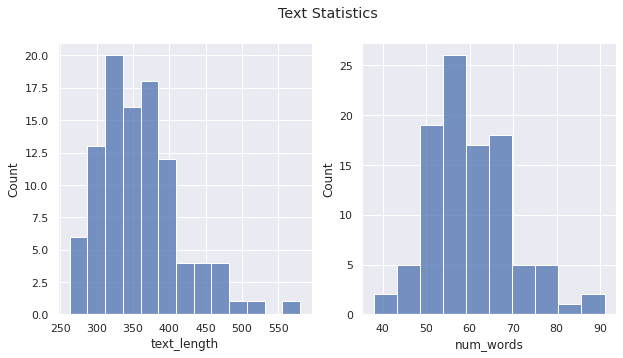

One of the most basic text analysis techniques is counting the frequency of words in the text. The following report shows the most common words in the text data, which can give us an idea of the overall topic and content of the text.



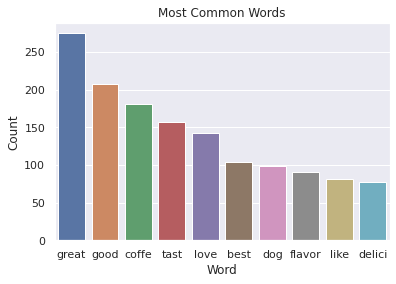

[('great', 275), ('good', 207), ('coffe', 181), ('tast', 157), ('love', 142), ('best', 104), ('dog', 99), ('flavor', 91), ('like', 81), ('delici', 78)]
A word cloud is a visual representation of the most common words in a piece of text, where the size of each word corresponds to its frequency. The word cloud can help us quickly identify the main themes and topics in the text data.



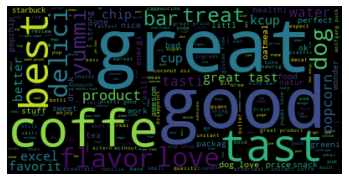

Sentiment analysis is a technique used to determine the emotional tone of a piece of text. The following report shows the sentiment of the text data and provides a breakdown of positive, negative, and neutral sentiments.

{'positive_count': 100, 'negative_count': 0, 'neutral_count': 0, 'positive_percent': 100.0, 'negative_percent': 0.0, 'neutral_percent': 0.0}


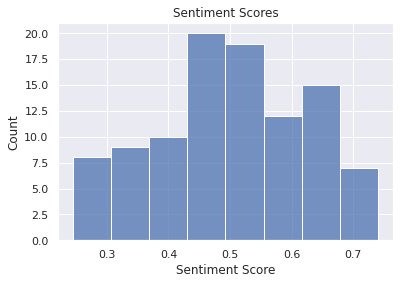

Corex is a topic modeling technique that helps identify latent topics in the text data. The following report shows the top topics extracted from the text data and provides a word cloud for each topic.

0: snack great, puck columbian, great product, spot everytim, forteeni, excel coffe, dental, believ, strong, sweet great
1: oil, like, favorit kind, cup starbuck, good flavor, excel, doggi, fake, delici snack, aftertast
2: bad pack, fair price, extrem, flavor great, textur, cherri, realli work, exactli, mini natur, best coconut
3: good tea, fuel cup, diet, great item, custom, bad split, yuck, item, hawaiian, ice
4: bad great, horribl, dri, feel, dispens garbag, coffe dispens, terrif coffe, total, issu, good gluten
5: lime, dark, good product, fuel, deliveri, product bad, dog dog, juic, delici best, asid uniqu
6: design, funki, super yummi, ground, snack eat, dont wast, oil amaz, isl, instant good, cut
7: love popchip, good delici, bar excel, smooth, organ coconut, steel cut, dark roast, 

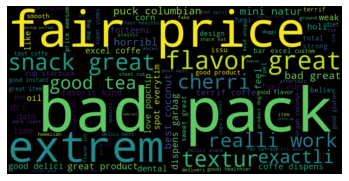

Extracting key sentences from a piece of text is a technique used to identify the most important or representative sentences in the text. The following report shows the top sentences for each topic of the text data.

Key sentences out of based on LSA algorithm: ['nice toy strong chewer puppi love without rope attach best food puzzl found yet light chewer dog toy plastic durabl enough dog toy keep pup busi great idea good toy small dog great feed option decent toy kept dog interest busi work perfect terrier three dogsno want much pup fun way intend great way entertain dog good altern buster cube well made food motiv much better bowl.', 'tasti sweet coffe lover ga station coffe love horribleveri disappoint great cappuccino yummi simpl great tast capuccino horrid ingredi awesom product yummilici think weak wateri star way pretti yummi use reg size set goof work ga station coffe dispens garbag french vanilla cappuccino good delici like.', 'stinki delight puppi love great treat dog love tin

In [9]:
df = merged_df[['Summary']]
df.columns = ['text']

origin_df, df, train_embedding, test_embedding, best_model = run_tcap(
    data_spec=DataSpec(df=df, text_column='text'),
    feature_extraction = FeatureExtraction(split_data = False))

In [10]:
# collect product ID and original text 
embedding_origin = pd.concat([merged_df[['ProductId','Summary']].reset_index(),\
                              train_embedding.reset_index()], axis = 1)
embedding_origin = embedding_origin.rename(columns={'Summary': 'text', 'ProductId':'target'})

In [11]:
#All of the similar text and target combinations are referring to different \
# Zuke's dog treat products with different flavors and ingredients.
find_similar_texts(embedding_origin, index = 1, top_similarities=5)

Original text: My cockapoo puppy loves these!
Great training treat, puppy LOVES them!!
Tastes Great!
Our Dog Loves Them
Zuke's Mini Naturals
Perfect for training
My dog likes these soft treats better than the traditional Zuke's treats
would be okay if they didnt get hard after 5 minutes
Love this product!
Great value
My Puppy LOVES these!
Very Yummy
Doesn't like
he loves them... but he gets the runs :(
My shiba loves these
Great price for a good solid training size treat for allergic dogs
dog treats
Great for training
Best Healthy Dog Treat Out There
A Great Training Treat
Original target: B0007A0AQW

Similar text: My cockapoo puppy loves these!
Great training treat, puppy LOVES them!!
Tastes Great!
Our Dog Loves Them
Zuke's Mini Naturals
Perfect for training
My dog likes these soft treats better than the traditional Zuke's treats
would be okay if they didnt get hard after 5 minutes
Love this product!
Great value
My Puppy LOVES these!
Very Yummy
Doesn't like
he loves them... but he get

In [12]:
# These appear to be reviews for different types of bars, such as Larabars, 
# KIND bars, and other similar products. They all seem to be similar in that 
# they are marketed as healthy, tasty snacks, but they differ in terms of ingredients, flavor and nutritional values
find_similar_texts(embedding_origin, index = 1, top_similarities=20)

Original text: My cockapoo puppy loves these!
Great training treat, puppy LOVES them!!
Tastes Great!
Our Dog Loves Them
Zuke's Mini Naturals
Perfect for training
My dog likes these soft treats better than the traditional Zuke's treats
would be okay if they didnt get hard after 5 minutes
Love this product!
Great value
My Puppy LOVES these!
Very Yummy
Doesn't like
he loves them... but he gets the runs :(
My shiba loves these
Great price for a good solid training size treat for allergic dogs
dog treats
Great for training
Best Healthy Dog Treat Out There
A Great Training Treat
Original target: B0007A0AQW

Similar text: My cockapoo puppy loves these!
Great training treat, puppy LOVES them!!
Tastes Great!
Our Dog Loves Them
Zuke's Mini Naturals
Perfect for training
My dog likes these soft treats better than the traditional Zuke's treats
would be okay if they didnt get hard after 5 minutes
Love this product!
Great value
My Puppy LOVES these!
Very Yummy
Doesn't like
he loves them... but he get

In [13]:
# These appear to be similar products, all of them seem to be different types 
# of water or coconut water with different features
find_similar_texts(embedding_origin, index = 75, top_similarities=5)

Original text: taste a bit alkaline
Delicious, soft water that seems to work well as an unsweetened Gatoraid substitute
If I'm going to buy bottled water, I'll seek this one out.
Good water, bottles are rather large
Tastes fine but kinda leaves your mouth dry??
Tastes Like Water
It's marketed water that is not at an ideal pH for the body
Tastes like water
Smooth and Delicious -- Some People Drink Alkaline Water for Health Benefits
I'm Not Buying It
High PH water
Health claims aside, it's a unique tasting water
Better water
I have to admit -- this is good bottled water.
It's Good Water, But...?
Will drinking this brand make you drink more water?
Clean taste
Essentia 9.5 pH Drinking Water
Premium water that you'd never be aware of without the premium price or label...
Water with an aftertaste
Original target: B005HG9ET0

Similar text: taste a bit alkaline
Delicious, soft water that seems to work well as an unsweetened Gatoraid substitute
If I'm going to buy bottled water, I'll seek this 

In [14]:
# hey are all coffee products with different flavors.
find_similar_texts(embedding_origin, index = 99, top_similarities=5)

Original text: This coffee isn't  my cup of tea.  Read detailed review.
One  of Starbucks Finest Blends
fine taste...
Vanilla and Coffee, excellent combination. But Starbucks burnt flavor is overpowering.
a bit on the bitter side
Decent-tasting coffee with subtle vanilla flavor
Reliably good flavored coffee for any occasion
Smells Good, Tastes Good . . .
Good coffee with pretty natural vanilla flavor
Ah-hhh... A pleasant "wake-me-up"...with or without creamer...
Smooth pleasant flavor- better than VIA vanilla
Very smooth.  Subtle is the key
so good i ordered more - subtle vanilla ground coffee
Smooth
It's vanilla, but it still tastes like Starbucks
Decent tasting coffee, just a bit bitter for my taste
Not A "Starbucks" Junkie But I LOVED This Premium Coffee!
Just Ok
Tastes better than it smells, but not as good as it looks!
Starbucks Fusions Vanilla
Original target: B0090X8IPM

Similar text: This coffee isn't  my cup of tea.  Read detailed review.
One  of Starbucks Finest Blends
fine t